# Least Squares

In [1]:
%%capture
import stata_setup, os
if os.name == 'nt':
    stata_setup.config('C:/Program Files/Stata17/','mp')
else:
    stata_setup.config('/usr/local/stata17','mp')

We load the data, rename the outcome variable, generate the indicator variables for ```year``` and ```cluster``` and define local Stata variables called ```journals``` and ```jel_imp``` which collects all relevant indicators.

In [2]:
%%stata -qui

use "../data/data", clear
rename log_flesch_kincaid_grade_level FKG
quietly tabulate year, generate(y_)  // años
quietly tabulate cluster, generate(c_)

local journals  ecm jpe qje res  //AER based category

local jel_imp a_imp b_imp c_imp  e_imp f_imp g_imp h_imp i_imp j_imp k_imp /// 
		l_imp m_imp n_imp o_imp p_imp q_imp r_imp y_imp z_imp // D JEL based case

Performing the OLS regression of $\mathbf{Y}$ on $\mathbf{X}$ using ```Stata```:

In [3]:
%%stata -qui
#delimit ;
reg FKG log_num_authors log_num_pages both_genders prop_women //comando mas impportante
			`journals' `jel_imp' y_2-y_20  c_2-c_215  jel_flag, vce(cluster cluster);
matrix b_selected = e(b)[1,"log_num_authors"],e(b)[1,"log_num_pages"], 
                    e(b)[1,"both_genders"],e(b)[1,"prop_women"],e(b)[1,"_cons"];
#delimit cr

Printing a subset of
the OLS estimate $\widehat{\beta}$ (originally a $262\times 1$ vector)

In [4]:
%%stata
matrix list b_selected


b_selected[1,5]
    log_num_au~s  log_num_pa~s  both_genders    prop_women         _cons
y1    -.00397377     .01915903     .00059809    -.01889331     2.7023992


Predicting the _fitted values_ and the _residuals_, then format them to be displayed with up to 4 decimals only along with other variables.

In [5]:
%%stata -qui  
predict FKG_hat, xb
predict double e_hat, residuals
format FKG FKG_hat e_hat log_num_authors log_num_pages %5.4f 

These command randomly sorts the rows of the data set in memory.

In [6]:
%%stata -qui
#delimit ;
set seed 42; tempvar sortorder; gen `sortorder' = runiform(); sort `sortorder';
#delimit cr

In [7]:
%stata list FKG FKG_hat e_hat log_num_authors log_num_pages both_genders prop_women in 1/20, table separator(20)


     +------------------------------------------------------------------------+
     |    FKG   FKG_hat     e_hat   log_n~rs   log_~ges   both_g~s   prop_w~n |
     |------------------------------------------------------------------------|
  1. | 2.8015    2.7041    0.0973     0.6931     3.5835          1         .5 |
  2. | 2.7776    2.7294    0.0482     0.6931     3.7136          0          0 |
  3. | 2.7829    2.7017    0.0812     1.0986     3.1781          0          0 |
  4. | 2.7027    2.7289   -0.0262     0.0000     3.5553          0          0 |
  5. | 2.8278    2.7167    0.1111     0.6931     3.3322          0          0 |
  6. | 2.3858    2.7210   -0.3352     0.6931     3.2958          0          0 |
  7. | 2.1718    2.7226   -0.5509     0.0000     3.8286          0          0 |
  8. | 2.5743    2.7851   -0.2108     0.0000     3.4657          0          0 |
  9. | 2.8177    2.8233   -0.0056     1.0986     4.1589          0          0 |
 10. | 2.7264    2.7048    0.0216     1

Printing the $TSS$

In [8]:
%stata display e(mss)+e(rss)

140.32277


Printing the $ESS$

In [9]:
%stata display e(mss)

12.920871


Printing the $RSS$

In [10]:
%stata display e(rss)

127.4019


Printing the $R^2$

In [11]:
%stata display e(mss)/(e(mss)+e(rss))

.09207965


## Leverage Values & LOO Regression

Extracting the leverage values

In [12]:
%%stata -qui
#delimit ;
reg FKG log_num_authors  log_num_pages both_genders prop_women
			`journals' `jel_imp' y_2-y_20  c_2-c_215  jel_flag;
#delimit cr
predict h, leverage
summarize h

Checking that $0\le h_{ii} \le 1$

In [13]:
%%stata
display "Min: " r(min)
display "Max: " r(max)


. display "Min: " r(min)
Min: .00481838

. display "Max: " r(max)
Max: 1

. 


Checking that $h_{ii}\ge 1/n$ by checking that $\min_{i=1,\ldots,n}(h_{ii})\ge 1/n$

In [14]:
%%stata
local sample_size = r(N)
local reciprocal = 1 / `sample_size'
local min_leverage = r(min)
display "Min leverage >= 1/N: " (`min_leverage' >= `reciprocal')


. local sample_size = r(N)

. local reciprocal = 1 / `sample_size'

. local min_leverage = r(min)

. display "Min leverage >= 1/N: " (`min_leverage' >= `reciprocal')
Min leverage >= 1/N: 1

. 


Checking that $\sum_{i=1}^n h_{ii}=k$

In [15]:
%%stata
egen total_h = total(h)
local rounded_total_h = ceil(total_h)
display "Rounded total of h: " `rounded_total_h'


. egen total_h = total(h)

. local rounded_total_h = ceil(total_h)

. display "Rounded total of h: " `rounded_total_h'
Rounded total of h: 262

. 


Extracting the matrix $\widehat{\beta}_{(-i)}-\widehat{\beta}$ for the `prop_women` regressor and the LOO residuals $\widetilde{e}_{i}$. Notice that Stata scales these parameters by their standard error.

In [16]:
%%stata -qui
predict dfbeta, dfbeta(prop_women)
gen double dfbeta_se = dfbeta*_se[prop_women]
cv_regress, generr(e_tilde)

SystemError: command cv_regress is unrecognized
r(199);


We identify an observation (row 1430) for which there is a perfect fit.

In [ ]:
%stata list FKG FKG_hat h dfbeta_se e_hat e_tilde in 1430, table separator(20)

In [ ]:
%%stata -fouta original,subset
frame put dfbeta_se e_tilde, into(original)

drop in 1430
frame put dfbeta_se e_tilde, into(subset)

In [ ]:
from sfi import Data
import numpy as np
import pandas as pd
dfbeta_py = subset[:,0]
e_tilde_py = subset[:,1]

Plotting the sets $\{\widehat{\beta}_{(-i)}-\widehat{\beta}:i=1,\ldots,n\}$ and $\{\widetilde{e}_{i}:i=1,\ldots,n\}$ against their indexes $i=1,\ldots,n$

NameError: name 'np' is not defined

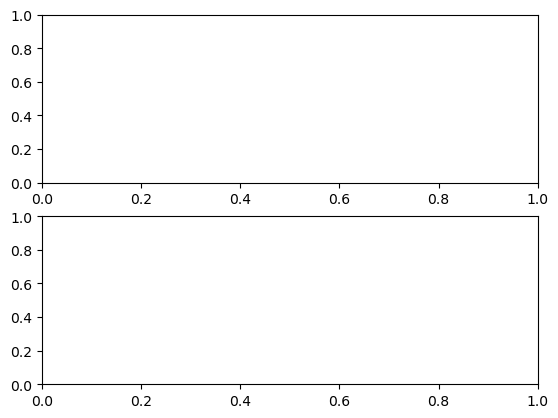

In [17]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(2)
axs[0].plot(np.linspace(1,e_tilde_py.size,num=e_tilde_py.size).astype(int), dfbeta_py)
axs[0].set_title(r'$\widehat{\beta}_{-i}-\widehat{\beta}$ vs $i=1,\ldots,n$')
axs[1].plot(np.linspace(1,e_tilde_py.size,num=e_tilde_py.size).astype(int), e_tilde_py,'tab:orange')
axs[1].set_title(r'$\widetilde{e}_{i}$ vs $i=1,\ldots,n$')
# Hide x labels and tick labels for top plots
for ax in axs.flat:
    ax.label_outer()


The '*prediction standard error*' is:

In [ ]:
print(np.sqrt(np.mean(e_tilde_py**2)))

## Residuals

In [ ]:
%%stata
gen e_bar = e_hat/sqrt(1-h)
format e_hat e_tilde e_bar %5.4f
list e_hat e_tilde e_bar in 1/10, table separator(20)
summarize e_hat e_tilde e_bar

## Covariance Matrix Estimation

**<span style="color:red">Homoskedasticity:</span>**

$$
\widehat{\mathbf{V}}_{\widehat{\beta}}^{0}=\left(\mathbf{X}^{\prime} \mathbf{X}\right)^{-1} s^{2}
$$

In [ ]:
%%stata -qui
#delimit ;
quietly reg FKG log_num_authors  log_num_pages both_genders prop_women
			`journals' `jel_imp' y_2-y_20  c_2-c_215  jel_flag;
matrix subV = (e(V)[1,1], e(V)[1,2], e(V)[1,3], e(V)[1,4], e(V)[1,262] \ 
               e(V)[2,1], e(V)[2,2], e(V)[2,3], e(V)[2,4], e(V)[2,262] \ 
               e(V)[3,1], e(V)[3,2], e(V)[3,3], e(V)[3,4], e(V)[3,262] \ 
               e(V)[4,1], e(V)[4,2], e(V)[4,3], e(V)[4,4], e(V)[4,262] \ 
               e(V)[262,1], e(V)[262,2], e(V)[262,3], e(V)[262,4], e(V)[262,262]);
#delimit cr

In [ ]:
%stata matrix list subV

**<span style="color:red">HC1:</span>** (most common in *econometrics*)

$$
\widehat{\mathbf{V}}_{\widehat{\beta}}^{\mathrm{HCl}}=\left(\frac{n}{n-k}\right)\left(\mathbf{X}^{\prime} \mathbf{X}\right)^{-1}\left(\sum_{i=1}^{n} X_{i} X_{i}^{\prime}\widehat{e}_{i}^{2} \right)\left(\mathbf{X}^{\prime} \mathbf{X}\right)^{-1}
$$


In [ ]:
%%stata -qui
#delimit ;
quietly reg FKG log_num_authors  log_num_pages both_genders prop_women
			`journals' `jel_imp' y_2-y_20  c_2-c_215  jel_flag, robust;
matrix subV = (e(V)[1,1], e(V)[1,2], e(V)[1,3], e(V)[1,4], e(V)[1,262] \ 
               e(V)[2,1], e(V)[2,2], e(V)[2,3], e(V)[2,4], e(V)[2,262] \ 
               e(V)[3,1], e(V)[3,2], e(V)[3,3], e(V)[3,4], e(V)[3,262] \ 
               e(V)[4,1], e(V)[4,2], e(V)[4,3], e(V)[4,4], e(V)[4,262] \ 
               e(V)[262,1], e(V)[262,2], e(V)[262,3], e(V)[262,4], e(V)[262,262]);
#delimit cr

In [ ]:
%stata matrix list subV

**<span style="color:red">HC2:</span>**

$$
\widehat{\mathbf{V}}_{\widehat{\beta}}^{\mathrm{HC2}}=\left(\mathbf{X}^{\prime} \mathbf{X}\right)^{-1}\left(\sum_{i=1}^{n} \left(1-h_{i i}\right)^{-1} X_{i}X_{i}^{\prime}\widehat{e}_{i}^{2} \right)\left(\mathbf{X}^{\prime} \mathbf{X}\right)^{-1}
$$

In [ ]:
%%stata -qui
#delimit ;
quietly reg FKG log_num_authors  log_num_pages both_genders prop_women
			`journals' `jel_imp' y_2-y_20  c_2-c_215  jel_flag, vce(hc2);
matrix subV = (e(V)[1,1], e(V)[1,2], e(V)[1,3], e(V)[1,4], e(V)[1,262] \ 
               e(V)[2,1], e(V)[2,2], e(V)[2,3], e(V)[2,4], e(V)[2,262] \ 
               e(V)[3,1], e(V)[3,2], e(V)[3,3], e(V)[3,4], e(V)[3,262] \ 
               e(V)[4,1], e(V)[4,2], e(V)[4,3], e(V)[4,4], e(V)[4,262] \ 
               e(V)[262,1], e(V)[262,2], e(V)[262,3], e(V)[262,4], e(V)[262,262]);
#delimit cr

In [ ]:
%stata matrix list subV

**<span style="color:red">HC3:</span>**

$$
\widehat{\mathbf{V}}_{\widehat{\beta}}^{\mathrm{HC3}}=\left(\mathbf{X}^{\prime} \mathbf{X}\right)^{-1}\left(\sum_{i=1}^{n}  \left(1-h_{i i}\right)^{-2}X_{i}X_{i}^{\prime}\widehat{e}_{i}^{2}  \right)\left(\mathbf{X}^{\prime} \mathbf{X}\right)^{-1}
$$

In [ ]:
%%stata -qui
#delimit ;
quietly reg FKG log_num_authors  log_num_pages both_genders prop_women
			`journals' `jel_imp' y_2-y_20  c_2-c_215  jel_flag, vce(hc3);
matrix subV = (e(V)[1,1], e(V)[1,2], e(V)[1,3], e(V)[1,4], e(V)[1,262] \ 
               e(V)[2,1], e(V)[2,2], e(V)[2,3], e(V)[2,4], e(V)[2,262] \ 
               e(V)[3,1], e(V)[3,2], e(V)[3,3], e(V)[3,4], e(V)[3,262] \ 
               e(V)[4,1], e(V)[4,2], e(V)[4,3], e(V)[4,4], e(V)[4,262] \ 
               e(V)[262,1], e(V)[262,2], e(V)[262,3], e(V)[262,4], e(V)[262,262]);
#delimit cr

In [ ]:
%stata matrix list subV

## Measures of Fit

**<span style="color:red">R-squared:</span>**
$$
R^{2}=1-\frac{\sum_{i=1}^{n} \widehat{e}_{i}^{2}}{\sum_{i=1}^{n}\left(y_{i}-\bar{y}\right)^{2}}
$$

In [ ]:
from sfi import Scalar
rsquared=Scalar.getValue('e(r2)')
print(rsquared)

**<span style="color:red">Adjusted R-squared:</span>**

$$
\bar{R}^{2}=1-\frac{(n-1) \sum_{i=1}^{n} \hat{e}_{i}^{2}}{(n-k) \sum_{i=1}^{n}\left(y_{i}-\bar{y}\right)^{2}}
$$

In [ ]:
radj=Scalar.getValue('e(r2_a)')
print(radj)

**<span style="color:red">(Alternative) R-squared:</span>**

$$
\widetilde{R}^{2}=1-\frac{\sum_{i=1}^{n} \widetilde{e}_{i}^{2}}{\sum_{i=1}^{n}\left(y_{i}-\bar{y}\right)^{2}}
$$

In [ ]:
from pystata import stata
stata.run('''
reg FKG log_num_authors log_num_pages both_genders prop_women  ///
			`journals' `jel_imp' y_2-y_20  c_2-c_215  jel_flag
''',quietly=True)
mss=Scalar.getValue('e(mss)')
rss=Scalar.getValue('e(rss)')
R2_tilde = 1 - (e_tilde_py**2).sum()/(mss+rss)
print(R2_tilde)

## Clustering

In [ ]:
%%stata
sort cluster
list FKG log_num_authors log_num_pages both_genders prop_women cluster ///
     in 4304/4322, table separator(20)

Running a regression with _robust_ standard errors

In [ ]:
%%stata -qui
#delimit ;
quietly reg FKG log_num_authors  log_num_pages both_genders prop_women
			`journals' `jel_imp' y_2-y_20  c_2-c_215  jel_flag, robust;
matrix subV = (e(V)[1,1], e(V)[1,2], e(V)[1,3], e(V)[1,4], e(V)[1,262] \ 
               e(V)[2,1], e(V)[2,2], e(V)[2,3], e(V)[2,4], e(V)[2,262] \ 
               e(V)[3,1], e(V)[3,2], e(V)[3,3], e(V)[3,4], e(V)[3,262] \ 
               e(V)[4,1], e(V)[4,2], e(V)[4,3], e(V)[4,4], e(V)[4,262] \ 
               e(V)[262,1], e(V)[262,2], e(V)[262,3], e(V)[262,4], e(V)[262,262]);
#delimit cr

In [ ]:
%stata matrix list subV

Running a regression with _clustered_ standard errors

In [ ]:
%%stata -qui
#delimit ;
quietly reg FKG log_num_authors  log_num_pages both_genders prop_women
			`journals' `jel_imp' y_2-y_20  c_2-c_215  jel_flag, vce(cluster cluster);
matrix subV = (e(V)[1,1], e(V)[1,2], e(V)[1,3], e(V)[1,4], e(V)[1,262] \ 
               e(V)[2,1], e(V)[2,2], e(V)[2,3], e(V)[2,4], e(V)[2,262] \ 
               e(V)[3,1], e(V)[3,2], e(V)[3,3], e(V)[3,4], e(V)[3,262] \ 
               e(V)[4,1], e(V)[4,2], e(V)[4,3], e(V)[4,4], e(V)[4,262] \ 
               e(V)[262,1], e(V)[262,2], e(V)[262,3], e(V)[262,4], e(V)[262,262]);
#delimit cr

In [ ]:
%stata matrix list subV